In [17]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [19]:
%matplotlib notebook

In [20]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [21]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


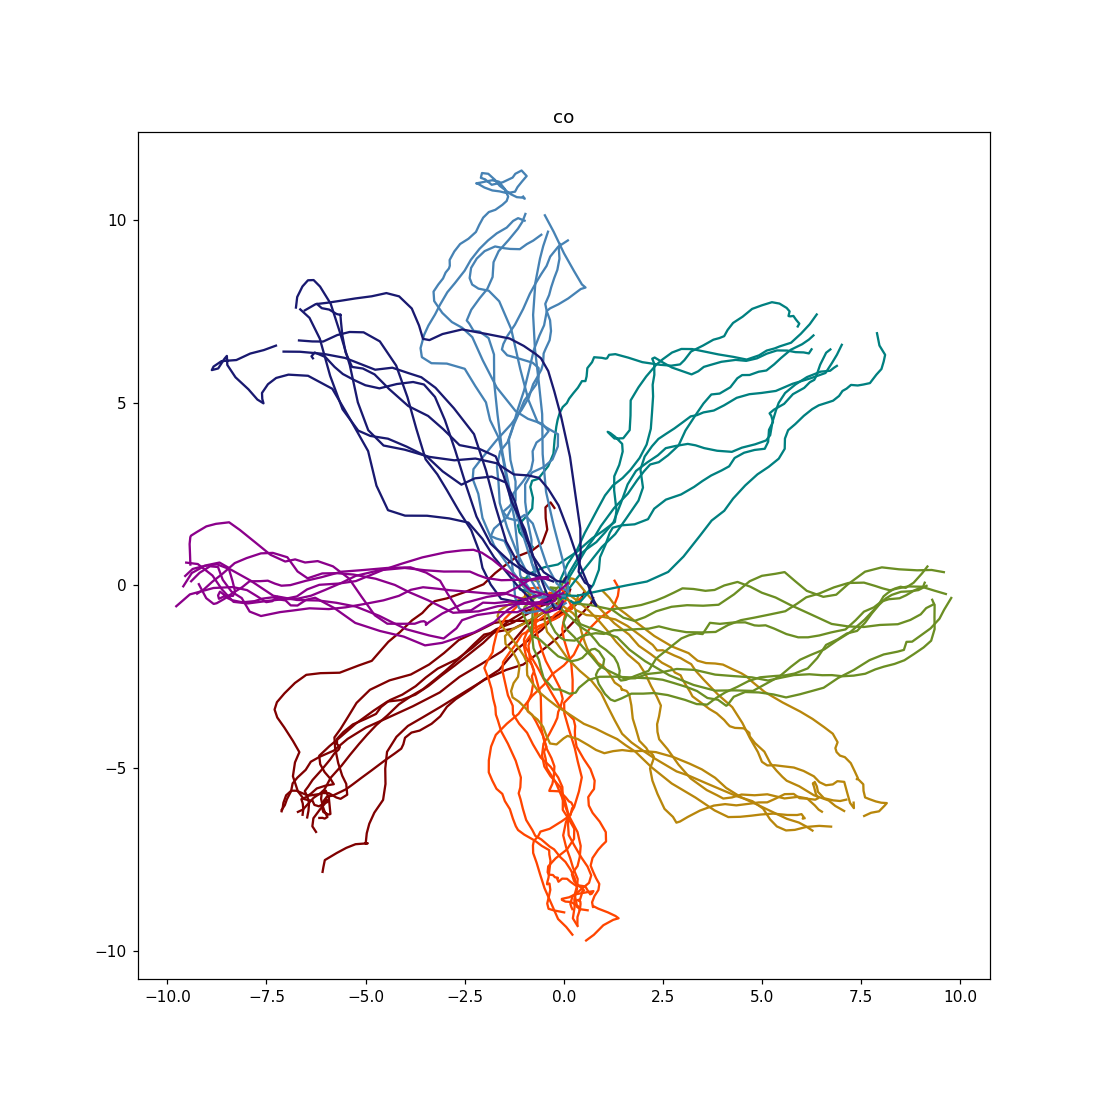

<IPython.core.display.Javascript object>


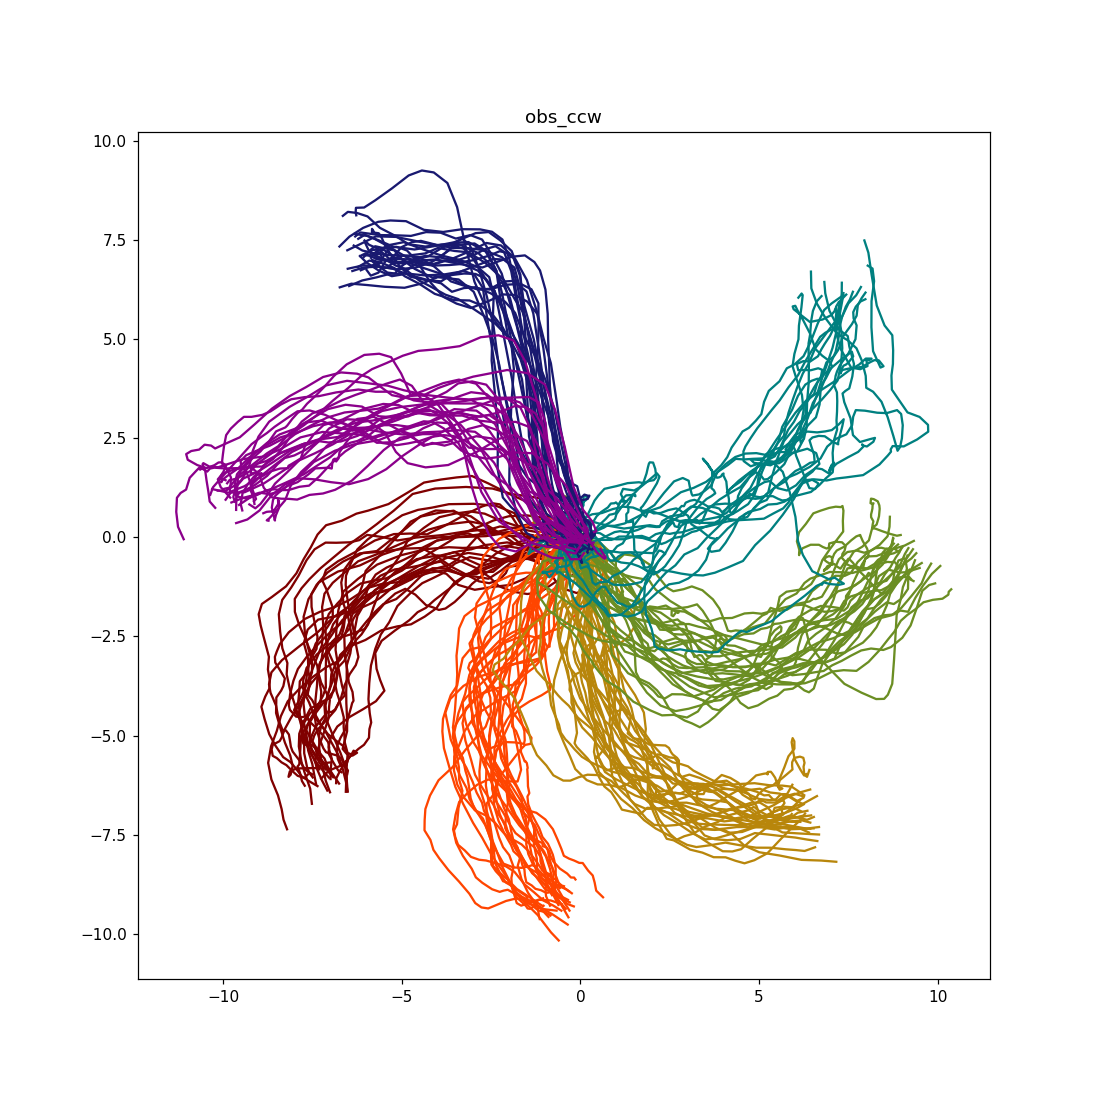

<IPython.core.display.Javascript object>


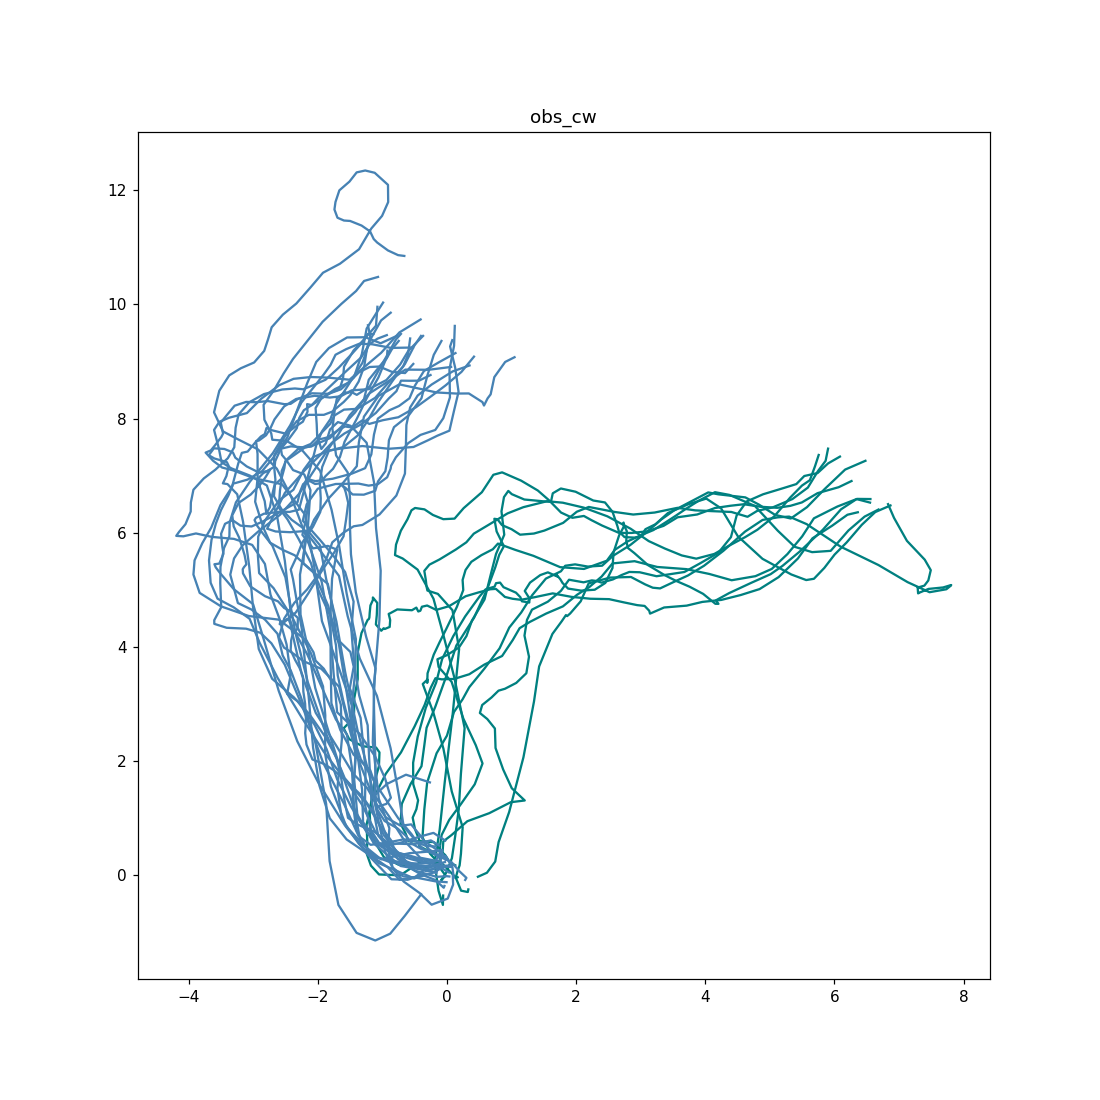

In [22]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [24]:
mag_bin_edges

array([[0.01594599, 0.8449011 , 1.32171331, 1.85882319, 3.2226475 ],
       [0.8449011 , 1.32171331, 1.85882319, 3.2226475 , 7.01433267]])

<IPython.core.display.Javascript object>


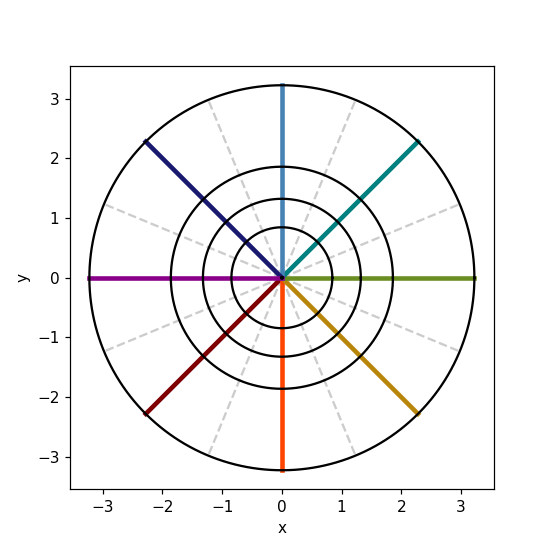

In [25]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

### Plot an example trial

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


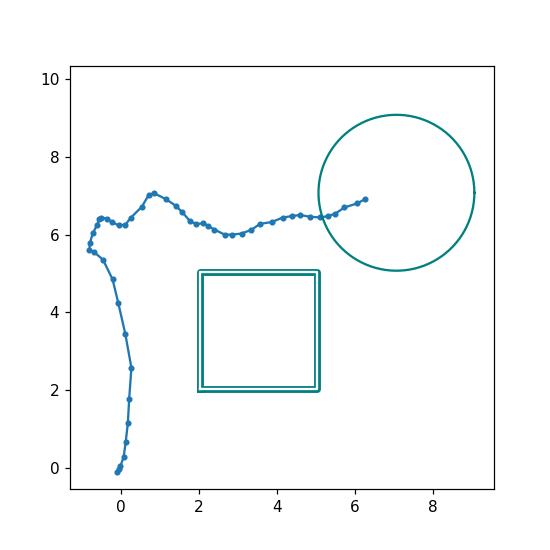

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [26]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

### Neural dynamics 

In [27]:
n_list = ['n_'+ str(i) for i in np.arange(num_neurons)]

sel_t_bin = (df['bin'] >= 0)
sel_t_bin_end = (df['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)
n_t = df.loc[sel_t,n_list]

sel_tp1_bin = (df['bin'] >= 1)
sel_tp1_bin_end = (df['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)
n_tp1 = df.loc[sel_tp1,n_list]

# regression: 
#ridge parameter from Preeya: 2500
clf = Ridge(alpha=2500)
clf.fit(np.array(n_t), np.array(n_tp1))

An = clf.coef_
bn = clf.intercept_

#Put into numpy matrices
An_m = np.mat(An)
bn_m = np.mat(bn).T

n_t_m = np.mat(n_t).T
n_tp1_m = np.mat(n_tp1).T
nhat_tp1 = An_m*n_t_m+bn_m

#sanity check we can use the dynamics parameters:
total_cov = np.cov(n_tp1_m)
total_var = np.trace(total_cov)

res_hat = nhat_tp1-n_tp1_m #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_var = np.trace(res_cov)

pred_cov = np.cov(nhat_tp1)
pred_var = np.trace(pred_cov)

print('sanity check on neural dynamics fit:')
print('viveks test R2: ', 1-res_var/total_var)
print('true R2: ', clf.score(n_t, n_tp1))

#Calculate mean activity for all neurons @ bin=0 to initialize future simulations: 
sel_bin = (df['bin'] == 0)
n_mean_init = df.loc[sel_bin, n_list].mean()

sanity check on neural dynamics fit:
('viveks test R2: ', 0.24517725254512746)
('true R2: ', 0.2451772525451282)


### Form matrices

In [28]:
kin_var = ['kin_px', 'kin_py', 'kin_vx', 'kin_vy']
num_kin = len(kin_var)
offset_var = ['offset']
num_offset = len(offset_var)

#F: 5x5
sel_F = np.array([0,2,3,5,6])
F = decoder['F'][sel_F, :]
F = F[:,sel_F]
print(F.shape)
F = xr.DataArray(F, coords={'out':kin_var+offset_var, 'in':kin_var+offset_var}, dims=['out', 'in'])

#K: 5xnum_neurons
sel_K = np.array([0,2,3,5,6])
Kn = decoder['K'][sel_K, :] #decoder mapping neural to control

(5L, 5L)


In [29]:
#DEFINE DYNAMICS FOR LQR:
A_list, A_dic, B = bmi_b.def_nk_AB(An_m, bn_m, Kn, F, num_neurons, num_kin)
state_dim = num_neurons+num_kin+1
state_label = n_list+kin_var+offset_var

In [57]:
#DEFINE MOVEMENTS FOR LQR SIMULATION
target_list = range(num_targets)
task_rot_list = [0,1.1,1.2]
center = np.array([0,0])
#waypoint parameters:
obs_margin = 6
waypoint_speed = 10
move_lqr = bmi_b.def_movements_for_nk_lqr(target_list, task_rot_list, center, target_pos, obs_pos, n_mean_init, obs_margin, waypoint_speed, state_dim, num_neurons)


In [31]:
A_dic['n_null']

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.03104744,  0.05586906, -0.33756993, ...,  0.5       ,
         0.        ,  0.17673329],
       [-0.0623252 , -0.02020976, -0.39146454, ...,  0.        ,
         0.5       , -0.11618373],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [33]:
#DEFINE QR
Qfp_s = 1e7
Qfv_s = Qfp_s
Qp_s = 0
Qv_s = 0
R_s = 1

Q_f, Q, R = bmi_b.def_nk_QR(Qfp_s, Qfv_s, Qp_s, Qv_s, R_s, state_label, state_dim, num_neurons, num_kin, n_list, kin_var, offset_var)

In [81]:
#FOR ONE MOVEMENT, DEFINE MODEL: 
task = 1.2
target = 5
m = 'n_do'

#unpack states: 
state_T = copy.deepcopy(move_lqr[target,task]['state_waypoint'])
# state_T[num_neurons+2] = 0
# state_T[num_neurons+3] = 0
state_init = move_lqr[target,task]['state_init']
input_label = n_list

A = np.mat(A_dic[m])
A_move = copy.deepcopy(A)
#modify dynamics with offset due to target state:
I = np.mat(np.eye(state_dim))
A_offset = (A_move-I)*state_T
A_move[:,-1] = A_move[:,-1] + A_offset

B = np.mat(B)







<IPython.core.display.Javascript object>


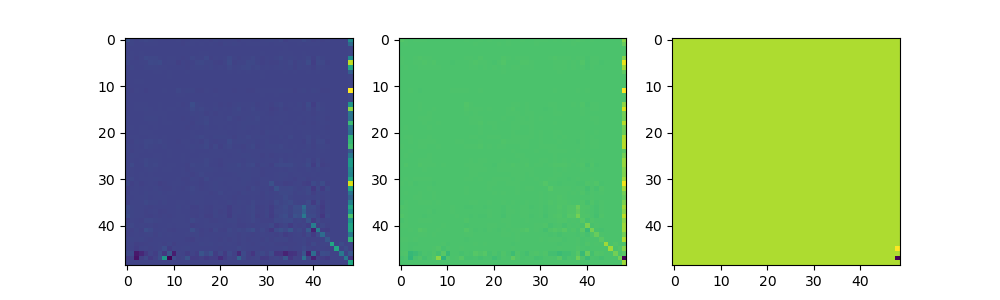

In [87]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(A)

plt.subplot(1,3,2)
plt.imshow(A_move)

plt.subplot(1,3,3)
plt.imshow(A_move-A)

In [89]:
#center-out sim
A_sel = A_move
horizon = 21
K = bmi_b.dlqr(A_sel,B,Q,R,Q_f=Q_f,T=horizon,max_iter=1e5)

u_da, state_da, state_e_da, sim_len = \
bmi_b.sim_lqr_nk_co_trial_finite_horizon(A_sel,B,K,\
horizon,state_T, state_init, state_label, input_label, num_neurons, max_iter=1e5, hold_req=2, target_r=1.7)

<IPython.core.display.Javascript object>


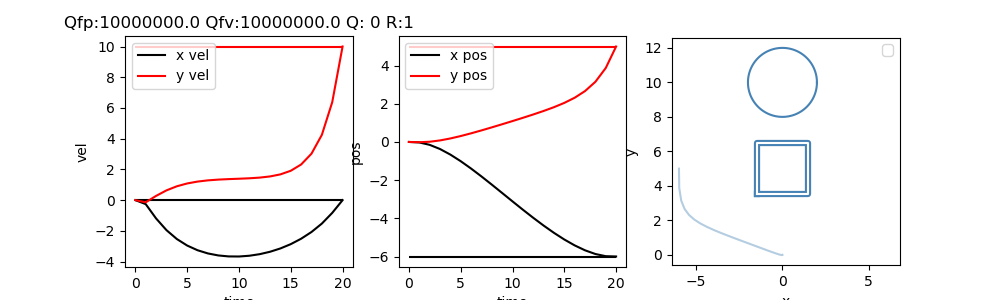

In [94]:
#plot diagnostics: 
target_da = xr.DataArray(state_T, coords={'v':n_list+kin_var+offset_var, 'obs':[0]},\
                           dims=['v', 'obs'])


plt.figure(figsize=(10,3))
#------------------------------------------------------------------
kin_color = {'x':'k', 'y':'r'}
#VELOCITY PLOT
plt.subplot(1,3,1)
x = state_da.loc['kin_vx',:]
y = state_da.loc['kin_vy',:]        
plt.plot(x,'-', alpha=1, label='x vel', color=kin_color['x']) # label=k
plt.plot(y,'-', alpha=1, label='y vel', color=kin_color['y'])
plt.hlines(target_da.loc['kin_vx', 0], 0, horizon-1, color=kin_color['x']) #label='wp x'
plt.hlines(target_da.loc['kin_vy', 0], 0, horizon-1,color=kin_color['y'])# label='wp y'

plt.xlabel('time')
plt.ylabel('vel')
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  

#------------------------------------------------------------------
kin_color = {'x':'k', 'y':'r'}
#VELOCITY PLOT
plt.subplot(1,3,2)
x = state_da.loc['kin_px',:]
y = state_da.loc['kin_py',:]        
plt.plot(x,'-', alpha=1, label='x pos', color=kin_color['x']) # label=k
plt.plot(y,'-', alpha=1, label='y pos', color=kin_color['y'])
plt.hlines(target_da.loc['kin_px', 0], 0, horizon-1, color=kin_color['x']) #label='wp x'
plt.hlines(target_da.loc['kin_py', 0], 0, horizon-1,color=kin_color['y'])# label='wp y'

plt.xlabel('time')
plt.ylabel('pos')
plt.legend()
# plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  



#------------------------------------------------------------------
plt.subplot(1,3,3)
x = state_da.loc['kin_px',:]
y = state_da.loc['kin_py',:]        
c = target_color[target]
plt.plot(x,y,'-', alpha=0.4,color=c) # label=k

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 


bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  


In [95]:
#Sanity check: confirm state evolves as it is supposed to:
n_da = state_da.loc[n_list,:]
Kn_m = np.mat(Kn)
n2k = xr.DataArray(Kn_m*n_da, coords={'v':kin_var+offset_var,'obs':range(n_da.shape[1])}, dims=['v','obs'])

k_da = state_da.loc[kin_var+offset_var,:]
F_m = np.mat(F)
k2k = F_m*k_da

In [96]:
khat = n2k+k2k

In [101]:
i=1
khat.loc[:,i]

<xarray.DataArray (v: 5)>
array([-0.15043 ,  0.010738, -1.19214 ,  0.275946,  1.      ])
Coordinates:
    obs      int32 1
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [102]:
state_da.loc[kin_var+offset_var,i+1]

<xarray.DataArray (v: 5)>
array([-0.15043 ,  0.010738, -1.19214 ,  0.275946,  1.      ])
Coordinates:
    obs      int32 2
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

### Inspect individual movements: 

<IPython.core.display.Javascript object>


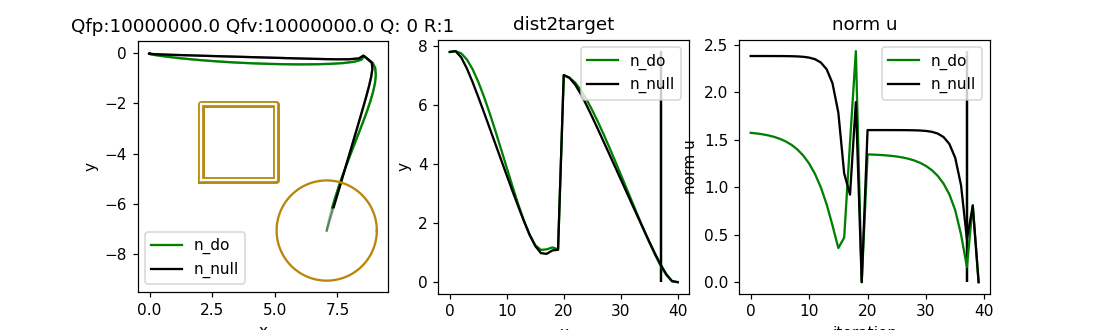

In [455]:
#Plot each on the same subplot
#Visualize results: 
target = 2
task = 1.2 #1.2


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
plt.figure(figsize=(10,3))

model_list = ['n_do', 'n_null']
#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,1)
for i,m in enumerate(model_list): #enumerate(task_models[task]):
    state_da = lqr_sim[target,task,m]['state_da']
    sim_len = lqr_sim[target,task,m]['sim_len']
    
    
    x = state_da.loc['kin_px',:]
    y = state_da.loc['kin_py',:]        
    plt.plot(x,y,'-', alpha=0.4, color=model_color[m]) # label=k
    
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]
    plt.plot(x,y,'-', label=m, color=model_color[m])

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 

c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))


plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  

#------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,2)
for i,m in enumerate(model_list): #for i,m in enumerate(task_models[task]):    
    e_da = lqr_sim[target,task,m]['state_e_da'].loc[['kin_px', 'kin_py'],:]
    sim_len = lqr_sim[target,task,m]['sim_len']
    norm_e = np.linalg.norm(e_da,axis=0)
    plt.plot(norm_e,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_e.min(), norm_e.max(), color=model_color[m]) #label=k+' done!'

    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('dist2target')     

#------------------------------------------------------------------
#INPUT PLOTS:
plt.subplot(1,3,3)
# for i,m in enumerate(task_models[task]):
for i,m in enumerate(model_list):    
    u_da = lqr_sim[target,task,m]['u_da']    
    sim_len = lqr_sim[target,task,m]['sim_len']
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.plot(norm_u,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_u.min(), norm_u.max(), color=model_color[m]) #label=k+' done!'
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()



In [456]:
#Waypoint:
wp = xr.DataArray(move_lqr[target,task]['state_waypoint'], coords={'v':n_list+kin_var+offset_var, 'obs':[0]}, dims = ['v', 'obs'])
wp.loc[kin_var]

<xarray.DataArray (v: 4, obs: 1)>
array([[ 7.778175],
       [ 0.707107],
       [ 7.071068],
       [-7.071068]])
Coordinates:
  * obs      (obs) int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [457]:
#State at waypoint time:
T = task_models[task]['n_do']['T']
lqr_sim[target,task,'n_do']['h0']['state_da'].loc[kin_var,T-1]

<xarray.DataArray (v: 4)>
array([ 8.73067 , -0.245388,  1.746763, -1.746764])
Coordinates:
    obs      int32 20
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [458]:
#State ERROR at waypoint time:
T = task_models[task]['n_do']['T']
lqr_sim[target,task,'n_do']['h0']['state_e_da'].loc[kin_var,T-1]

<xarray.DataArray (v: 4)>
array([ 0.952495, -0.952495, -5.324304,  5.324304])
Coordinates:
    obs      int32 20
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [281]:
np.linalg.pinv(An_m)

matrix([[ 9.72304947e+00,  8.13328498e-01,  6.53482590e+00, ...,
          4.52075561e-02,  2.09146576e-01, -7.76759415e-01],
        [ 2.64092355e+00,  2.91957379e+00, -9.52876791e+01, ...,
         -5.42509679e-01,  8.41180542e-01, -3.18540748e+00],
        [ 8.38371085e+00, -3.69782388e+01,  5.69242069e+01, ...,
         -5.73348178e-01,  3.69252603e+00, -6.87919270e-01],
        ...,
        [-5.36062496e+00,  1.60060441e+01, -1.11217099e+02, ...,
          1.35592444e+00, -1.49367223e+00,  2.49963288e-02],
        [-4.78023945e-01,  3.19904589e+00,  2.71819335e+00, ...,
         -2.75727589e-01,  2.60575060e+00, -2.15162542e-01],
        [-1.13217341e+01,  3.93557572e+01, -1.33613389e+02, ...,
          1.15869805e-01, -4.10204242e+00,  5.82879763e+00]])

In [232]:
#State at waypoint time (FULL TRIAL):
T = task_models[task]['n_do']['T']
lqr_sim[target,task,'n_do']['state_da'].loc[kin_var,T-2]

<xarray.DataArray (v: 4)>
array([-0.094508, -8.539125,  1.189737, -0.843403])
Coordinates:
    obs      int32 19
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [233]:
#State E at waypoint time (FULL TRIAL):
T = task_models[task]['n_do']['T']
lqr_sim[target,task,'n_do']['state_e_da'].loc[kin_var,T-2]

<xarray.DataArray (v: 4)>
array([-0.801614, -0.76095 ,  8.260805,  6.227665])
Coordinates:
    obs      int32 19
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

In [243]:
#Target:
tp = xr.DataArray(move_lqr[target,task]['state_T'], coords={'v':n_list+kin_var+offset_var, 'obs':[0]}, dims = ['v', 'obs'])
tp.loc[kin_var]

<xarray.DataArray (v: 4, obs: 1)>
array([[-7.071068],
       [-7.071068],
       [ 0.      ],
       [ 0.      ]])
Coordinates:
  * obs      (obs) int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy'

### Collect all the movement data into a df: 

In [93]:
#start with one movement

target = 7
task = 1.2
m = 'n_do'
#neural state, cursor state, input, neural "command"

state_da = lqr_sim[target,task,m]['state_da']
u_da = lqr_sim[target,task,m]['u_da']    


In [117]:
state_e_da = lqr_sim[target,task,m]['state_e_da']
state_e_da.shape

(49L, 39L)

In [118]:
state_da.shape

(49L, 41L)

In [27]:
type(Kn)

numpy.ndarray

In [29]:
Kn.shape

(5L, 44L)

In [94]:
state_da

<xarray.DataArray (v: 49, obs: 41)>
array([[ 7.317073e-01,  1.074859e+00,  1.148507e+00, ...,  1.357483e+00,
         1.381153e+00,  1.333248e+00],
       [ 4.703833e-01,  4.020229e-01,  4.254107e-01, ...,  4.927242e-01,
         5.072531e-01,  4.781222e-01],
       [ 2.787456e-02,  5.593675e-01,  5.600821e-01, ..., -3.576666e-02,
         9.627361e-02,  2.126172e-02],
       ...,
       [ 0.000000e+00, -2.601346e-01, -1.242956e+00, ..., -9.153568e-01,
        -5.133571e-01, -3.401391e-04],
       [ 0.000000e+00, -1.404706e-01, -1.282894e+00, ...,  2.074356e+00,
         1.273869e+00,  6.804347e-04],
       [ 1.000000e+00,  1.000000e+00,  1.000000e+00, ...,  1.000000e+00,
         1.000000e+00,  1.000000e+00]])
Coordinates:
  * obs      (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39 40
  * v        (v) |S6 'n_0' 'n_1' 'n_2' 'n_3' ... 'kin_vx' 'kin_vy' 'offset'

In [95]:
n_da = state_da.loc[n_list,:]

In [96]:
n_da

<xarray.DataArray (v: 44, obs: 41)>
array([[ 0.731707,  1.074859,  1.148507, ...,  1.357483,  1.381153,  1.333248],
       [ 0.470383,  0.402023,  0.425411, ...,  0.492724,  0.507253,  0.478122],
       [ 0.027875,  0.559368,  0.560082, ..., -0.035767,  0.096274,  0.021262],
       ...,
       [ 2.491289,  3.091734,  3.935919, ...,  3.353361,  3.124102,  2.895023],
       [ 0.595819,  0.772963,  0.928712, ...,  0.851913,  0.847254,  0.792236],
       [ 2.954704,  1.569889,  1.24682 , ...,  1.231463,  1.287262,  1.237015]])
Coordinates:
  * obs      (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39 40
  * v        (v) |S6 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'

In [97]:
type(F)

xarray.core.dataarray.DataArray

In [98]:
F

<xarray.DataArray (out: 5, in: 5)>
array([[ 1.      ,  0.      ,  0.07    ,  0.      ,  0.017673],
       [ 0.      ,  1.      ,  0.      ,  0.07    , -0.011618],
       [ 0.      ,  0.      ,  0.5     ,  0.      ,  0.176733],
       [ 0.      ,  0.      ,  0.      ,  0.5     , -0.116184],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.      ]])
Coordinates:
  * in       (in) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'
  * out      (out) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [101]:
#Get neural and kinematic contributions to next kinematic state
n_da = state_da.loc[n_list,:]
Kn_m = np.mat(Kn)
n2k = xr.DataArray(Kn_m*n_da, coords={'v':kin_var+offset_var,'obs':range(n_da.shape[1])}, dims=['v','obs'])

k_da = state_da.loc[kin_var+offset_var,:]
F_m = np.mat(F)
k2k = F_m*k_da

In [102]:
n2k

<xarray.DataArray (v: 5, obs: 41)>
array([[-0.043687, -0.128962, -0.159716, ..., -0.023241,  0.007961, -0.012199],
       [-0.002429, -0.109647, -0.119498, ...,  0.035287, -0.052007,  0.013003],
       [-0.436868, -1.289622, -1.597163, ..., -0.232412,  0.079605, -0.121987],
       [-0.024287, -1.096475, -1.194981, ...,  0.352875, -0.52007 ,  0.130028],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ]])
Coordinates:
  * obs      (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39 40
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [103]:
khat = n2k+k2k

In [104]:
i=0
khat.loc[:,i]

<xarray.DataArray (v: 5)>
array([-0.026013, -0.014047, -0.260135, -0.140471,  1.      ])
Coordinates:
    obs      int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [106]:
state_da.loc[kin_var+offset_var,i+1]

<xarray.DataArray (v: 5)>
array([-0.026013, -0.014047, -0.260135, -0.140471,  1.      ])
Coordinates:
    obs      int32 1
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [74]:
k2k.loc[:,i]

<xarray.DataArray (v: 5)>
array([ 0.017673, -0.011618,  0.176733, -0.116184,  1.      ])
Coordinates:
    obs      int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [75]:
n2k.loc[:,i]

<xarray.DataArray (v: 5)>
array([-0.043687, -0.002429, -0.436868, -0.024287,  0.      ])
Coordinates:
    obs      int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [105]:
state_da.loc[kin_var+offset_var,i+1]

<xarray.DataArray (v: 5)>
array([-0.026013, -0.014047, -0.260135, -0.140471,  1.      ])
Coordinates:
    obs      int32 1
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [76]:
state_da.loc[kin_var+offset_var,i]

<xarray.DataArray (v: 5)>
array([0., 0., 0., 0., 1.])
Coordinates:
    obs      int32 0
  * v        (v) |S6 'kin_px' 'kin_py' 'kin_vx' 'kin_vy' 'offset'

In [34]:
n2k.shape

(5L, 41L)

In [40]:
k2k.shape

(5L, 41L)

In [ ]:
A_list, A_dic, B = bmi_b.def_nk_AB(An_m, bn_m, Kn, F, num_neurons, num_kin)

In [117]:
state_da.shape

(49L, 41L)

In [118]:
u_da.shape

(44L, 40L)

In [ ]:
#We need to compute Kn*n, so we can bin it.  
#I guess I should split state into two parts, multiply them separately, and recombine to confirm: 

A = lqr_sim[target,]